In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown as md
from collections import namedtuple
from dataclasses import dataclass
from typing import Any, List
import scipy
# %connect_info

In [2]:
display(md("### connect to board"))
# board @ Manny is 47; board @ Bill is 45
%run rocstar_init 47
tp.cal()
f.setup_waveform_readout()
f.set_calib_mode(calib_mode=True, sine_enable=True)
tdat = f.readout_one_trigger()

### connect to board

rocstar_init.py starting at Wed May  1 12:29:57 2019
connecting to board 47
++ check whether board is alive
ping -c 1 192.168.1.47
192.168.1.47 is alive
++ ssh connect
ssh root@192.168.1.47
 uptime  12:29:06 up 47 min,  0 users,  load average: 7.99, 7.97, 7.58 
# Check that /mnt/uzed is present
/mnt/uzed
# Configure Zynq PL
cat uzed_rocstar_11.bin >> /dev/xdevcfg
# Check Zynq PL bus I/O
./rd 0002 && ./rd 0001
busio: rd 0002 ==> dead
busio: rd 0001 ==> beef
# Check that /mnt/uzed is present
/mnt/uzed
# Configure Spartan6 FPGA
./spartan6_config.elf rocstar.bin
main program, 2019-02-15 13:10
rd 0 -> 1752, rd 1 -> beef, rd 2 -> dead
busrd(5) -> 10
INIT asserted OK
busrd(5) -> 0
INIT deasserted OK
reading Spartan6 configuration data from rocstar.bin
1000000
2000000
3000000
sent 3319844 configuration bytes to Spartan6
rd 5 -> 0001
# Check Spartan6 bus I/O
./v5rd 0013 && ./v5rd 0001
busio: a7rd 0013 ==> 6666
busio: a7rd 0001 ==> beef
# Start weiwei server
./server.elf >> /dev/null &
-- ssh di

### trigger, read, and display one waveform

put DRS4 inputs into calibration mode, sine waves ON
s6:0006 = 0000000000110000
tcell=0101100001 ddfdat[3]=100101100001
tcell=161 ddfdat[3]=961


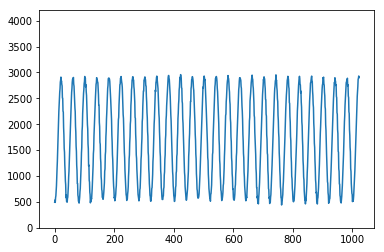

In [3]:
display(md("### trigger, read, and display one waveform"))
which_drs = 1
f.set_calib_mode(calib_mode=True, sine_enable=True)
tdat = f.readout_one_trigger(verbose=False, whichdrs=which_drs)
plt.plot(tdat.wavedat)
plt.axis([None,None,0,4200])
print("tcell={:010b} ddfdat[3]={:010b}".format(
    tdat.tcell, tdat.ddfdat[3]))
print("tcell={:03x} ddfdat[3]={:03x}".format(
tdat.tcell, tdat.ddfdat[3]))

### trigger, read, and display one waveform

put DRS4 inputs into calibration mode, sine waves OFF
s6:0006 = 0000000000000000
tcell=0100110000 ddfdat[3]=100100110000
tcell=130 ddfdat[3]=930


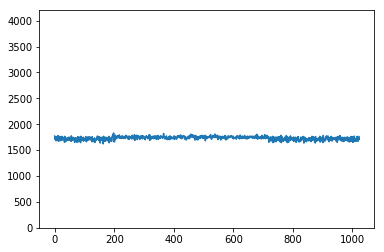

In [4]:
display(md("### trigger, read, and display one waveform"))
f.set_calib_mode(calib_mode=True, sine_enable=False)
tdat = f.readout_one_trigger(verbose=False, whichdrs=which_drs)
plt.plot(tdat.wavedat)
plt.axis([None,None,0,4200])
print("tcell={:010b} ddfdat[3]={:010b}".format(
    tdat.tcell, tdat.ddfdat[3]))
print("tcell={:03x} ddfdat[3]={:03x}".format(
tdat.tcell, tdat.ddfdat[3]))

In [5]:
@dataclass
class PedestalRun:
    whichdrs: int
    ichannel: int
    events: List[Any]
    peds: Any  # numpy array

pedruns = {}

print(time.ctime())
for which_drs in [0,1]:
    for ichnl in range(8):
        print("\nwhich_drs={} ichnl={}".format(which_drs,ichnl))
        pr = PedestalRun(whichdrs=which_drs,
                         ichannel=ichnl,
                         events=None,
                         peds=None)
        pedruns[(which_drs, ichnl)] = pr
        events = []  # list of Event objects
        pr.events = events
        for i in range(1000):
            ev = f.readout_one_trigger(verbose=False, whichdrs=which_drs)
            print(" i={:d} len(events)={:d} tcell={:d}     ".format(
                i, len(events), ev.tcell), 
                end='\r', flush=True)
            events.append(ev)
        #
        psum = np.zeros(1024)
        npsum = np.zeros(1024)
        for e in events:
            cellid = e.tcell
            wd = e.wavedat
            wd -= np.mean(wd)  # temporary?!
            l = len(wd)
            z = np.zeros(1024-l)
            o = np.ones(l)
            onepad = np.roll(np.hstack((o,z)), cellid)
            npsum += onepad
            adcpad = np.roll(np.hstack((wd,z)), cellid)
            psum += adcpad
        for cell in range(1024):
            if npsum[cell]>0:
                psum[cell] /= npsum[cell]
        pr.peds = psum
        for e in events:
            l = len(e.wavedat)
            p = np.roll(psum, -e.tcell)
            wps = e.wavedat - p[:l]
            e.wps = wps  # "wave with pedestal subtraction"
print("\n\n" + time.ctime())

Wed May  1 12:31:54 2019

which_drs=0 ichnl=0
 i=999 len(events)=999 tcell=19       
which_drs=0 ichnl=1
 i=999 len(events)=999 tcell=675      
which_drs=0 ichnl=2
 i=999 len(events)=999 tcell=706      
which_drs=0 ichnl=3
 i=999 len(events)=999 tcell=478      
which_drs=0 ichnl=4
 i=999 len(events)=999 tcell=127      
which_drs=0 ichnl=5
 i=999 len(events)=999 tcell=565      
which_drs=0 ichnl=6
 i=999 len(events)=999 tcell=183      
which_drs=0 ichnl=7
 i=999 len(events)=999 tcell=408      
which_drs=1 ichnl=0
 i=999 len(events)=999 tcell=185      
which_drs=1 ichnl=1
 i=999 len(events)=999 tcell=161      
which_drs=1 ichnl=2
 i=999 len(events)=999 tcell=1015     
which_drs=1 ichnl=3
 i=999 len(events)=999 tcell=738      
which_drs=1 ichnl=4
 i=999 len(events)=999 tcell=216      
which_drs=1 ichnl=5
 i=999 len(events)=999 tcell=777      
which_drs=1 ichnl=6
 i=999 len(events)=999 tcell=690      
which_drs=1 ichnl=7
 i=999 len(events)=999 tcell=833      

Wed May  1 12:38:45 2019


In [6]:
for k in sorted(pedruns.keys()):
    pr = pedruns[k]
    rmslist = [np.std(e.wps) for e in pr.events]
    print("drs {} chnl {}".format(pr.whichdrs, pr.ichannel),
        "rms after ped sub (counts): mean {:.2f}".format(
            np.mean(rmslist)),
        "median {:.2f}".format(
            np.median(rmslist)))

drs 0 chnl 0 rms after ped sub (counts): mean 6.04 median 5.23
drs 0 chnl 1 rms after ped sub (counts): mean 5.92 median 5.24
drs 0 chnl 2 rms after ped sub (counts): mean 5.94 median 5.22
drs 0 chnl 3 rms after ped sub (counts): mean 5.97 median 5.24
drs 0 chnl 4 rms after ped sub (counts): mean 5.89 median 5.24
drs 0 chnl 5 rms after ped sub (counts): mean 5.90 median 5.20
drs 0 chnl 6 rms after ped sub (counts): mean 6.00 median 5.26
drs 0 chnl 7 rms after ped sub (counts): mean 6.21 median 5.26
drs 1 chnl 0 rms after ped sub (counts): mean 6.30 median 5.47
drs 1 chnl 1 rms after ped sub (counts): mean 6.45 median 5.55
drs 1 chnl 2 rms after ped sub (counts): mean 6.23 median 5.56
drs 1 chnl 3 rms after ped sub (counts): mean 6.11 median 5.52
drs 1 chnl 4 rms after ped sub (counts): mean 6.42 median 5.51
drs 1 chnl 5 rms after ped sub (counts): mean 6.25 median 5.53
drs 1 chnl 6 rms after ped sub (counts): mean 6.24 median 5.48
drs 1 chnl 7 rms after ped sub (counts): mean 6.35 medi

#### 5 events, pedestal-subtracted

5.501826478269746
6.424985878545538
6.043176422861243
4.966611339421714
4.917499614206806


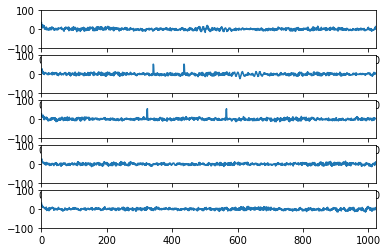

In [7]:
display(md("#### 5 events, pedestal-subtracted"))
n = 5; n0 = 10
plt.clf()
for i in range(n):
    plt.subplot(n,1,i+1)
    e = pedruns[(1,0)].events[n0+i]
    plt.plot(e.wps-np.mean(e.wps))
    plt.axis([0,1024,-100,100])
    print(np.std(e.wps[5:950]))

In [8]:
# you can skip this if you don't want to write out the data to disk
import h5py
hfnam = time.strftime("rsdata/rocstar_%Y%m%d_%H%M.hdf5")
print("hfnam = {}".format(hfnam))
hf = h5py.File(hfnam, "w")
hf.attrs["datetime"] = time.strftime("%Y%m%d %H%M%%S")
hf.attrs["rocstar_ipaddr"] = f.ipaddr
ndrs = 2 ; nchnl = 8 ; ncell = 1024
peds = hf.create_dataset("peds", (ndrs,nchnl,ncell), dtype="f4")
peds.attrs["comment"] = "pedestal for (idrs, jchannel, kcell)"
for idrs,jchnl in sorted(pedruns.keys()):
    peds[idrs,jchnl,:] = pedruns[(idrs,jchnl)].peds
max_wf_len = np.max([len(e.wavedat)
                     for e in pedruns[k].events
                     for k in pedruns])
max_num_events = np.max([len(pedruns[k].events) for k in pedruns])
print(max_wf_len, max_num_events)
drs_raw = hf.create_dataset("drs_raw", (ndrs,nchnl,max_num_events,max_wf_len), dtype="i2")
drs_raw.attrs["comment"] = \
    "raw DRS4 waveforms for (idrs, jchannel, kevent, lsample)"
drs_pedsub = hf.create_dataset("drs_pedsub", (ndrs,nchnl,max_num_events,max_wf_len), dtype="f4")
drs_pedsub.attrs["comment"] = \
    "pedestal-subtracted DRS4 waveforms for (idrs, jchannel, kevent, lsample)"
tcell = hf.create_dataset("tcell", (ndrs,nchnl,max_num_events), dtype="i2")
tcell.attrs["comment"] = """
DRS trigger cell for (idrs, jchannel, kevent)

note that a separate set of events was recorded for each (idrs, jchannel), 
so the trigger cell number is different for (idrs,1) than for (idrs,2) 
in this data sample
"""
for idrs,jchnl in sorted(pedruns.keys()):
    pr = pedruns[(idrs,jchnl)]
    for kevent in range(len(pr.events)):
        drs_raw[idrs,jchnl,kevent,:] = pr.events[kevent].wavedat
        drs_pedsub[idrs,jchnl,kevent,:] = pr.events[kevent].wps
        tcell[idrs, jchnl, kevent] = pr.events[kevent].tcell
hf.flush()
hf.close()
del hf

hfnam = rsdata/rocstar_20190501_1239.hdf5
1023 1000


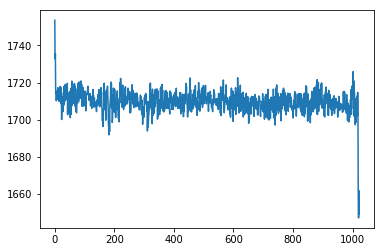

In [9]:
hf = h5py.File(hfnam, "r")
wps = hf["drs_pedsub"][:]
plt.plot(wps[0,0,10])
hf.close()
del hf